In [1]:
import pandas as pd
import numpy as np
import gc
from lightgbm import LGBMClassifier
import lightgbm
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('cleandata/train.csv')
data.fillna(np.nan, inplace=True)
data.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in data.columns]
data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [3]:
Y = data['TARGET']
X = data[list(data.columns[2:])]
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=0)
del data
gc.collect()

27

In [4]:
finalmodel = LGBMClassifier(n_estimators=7455,
                            learning_rate=0.00286,
                            num_leaves=32,
                            min_data_in_leaf=655,
                            max_depth=8,
                            reg_alpha=1.311,
                            reg_lambda=2.093,
                            min_split_gain=0.09443,
                            min_child_weight=32.54,
                            colsample_bytree=0.5547,
                            subsample=0.5301,
                            random_state=0)

finalmodel.fit(x_train,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5547,
               importance_type='split', learning_rate=0.00286, max_depth=8,
               min_child_samples=20, min_child_weight=32.54,
               min_data_in_leaf=655, min_split_gain=0.09443, n_estimators=7455,
               n_jobs=-1, num_leaves=32, objective=None, random_state=0,
               reg_alpha=1.311, reg_lambda=2.093, silent=True, subsample=0.5301,
               subsample_for_bin=200000, subsample_freq=0)

### Evaluate on the test set

In [5]:
y_predprob = finalmodel.predict_proba(x_test)
y_predclass = finalmodel.predict(x_test)

In [6]:
auc = roc_auc_score(y_test,y_predprob[:,1])
print('roc auc score: ',auc)

roc auc score:  0.7948755761454442


In [7]:
cm = confusion_matrix(y_test,y_predclass)
print('confusion matrix:')
print(cm)

confusion matrix:
[[56455   193]
 [ 4607   248]]


In [8]:
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_predprob[:,1])

plt.figure(figsize=(8, 6), dpi=144)
plt.plot(fpr, tpr, color='red')
plt.legend(['AUC={}'.format(round(auc,3))])
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('plot/roc_finalmodel.png')

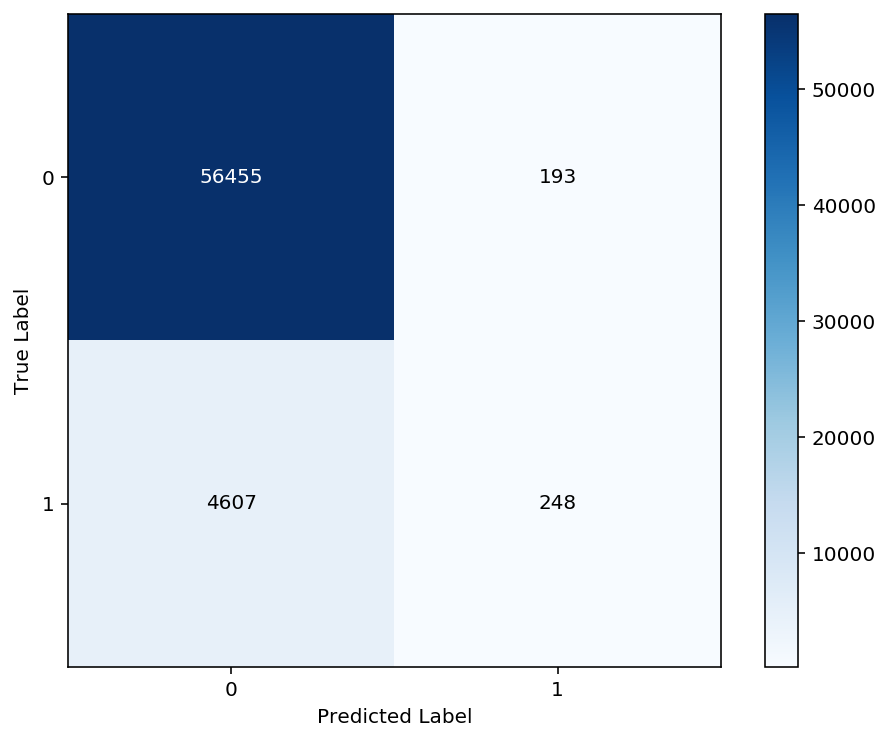

In [9]:
plt.figure(figsize=(8, 6), dpi=144)
plt.imshow(cm, interpolation='nearest', cmap=plt.get_cmap('Blues'))
plt.colorbar()
plt.xticks([0,1], [0,1])
plt.yticks([0,1], [0,1])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.text(0, 0, cm[0,0],verticalalignment='center', horizontalalignment='center', color='white')
plt.text(0, 1, cm[1,0],verticalalignment='center', horizontalalignment='center', color='black')
plt.text(1, 0, cm[0,1],verticalalignment='center', horizontalalignment='center', color='black')
plt.text(1, 1, cm[1,1],verticalalignment='center', horizontalalignment='center', color='black')

plt.savefig('plot/cm_finalmodel.png')

In [10]:
importance_value = finalmodel.feature_importances_
feature_importance = list(np.argsort(importance_value))[::-1]
col_list = list(X.columns)
max_num = 20
value = []
col = []
for i in range(max_num):
    index = feature_importance[i]
    value.append(importance_value[index])
    col.append(col_list[index])

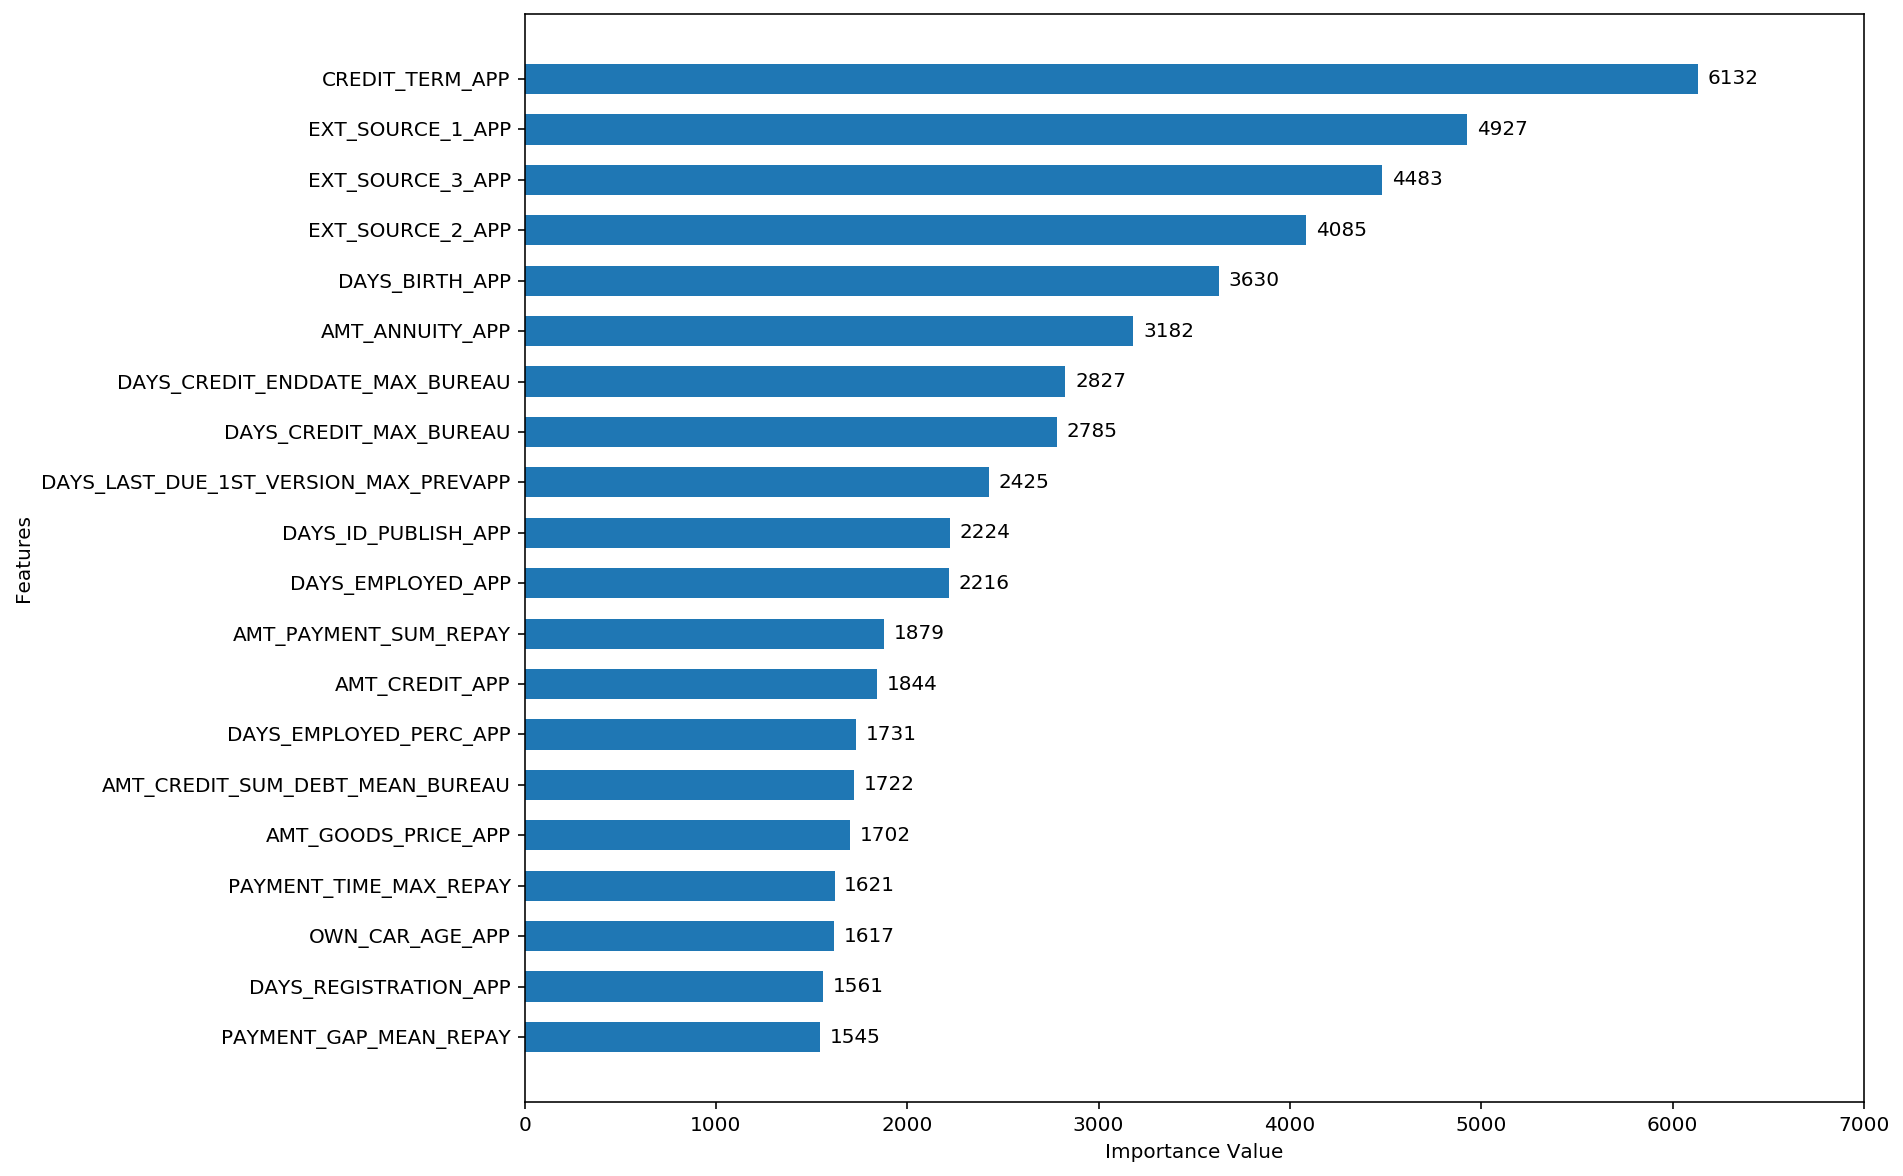

In [11]:
plt.figure(figsize=(12, 10), dpi=144)
plt.barh(y = col[::-1], height=0.6, width=value[::-1])
plt.ylabel('Features')
plt.xlabel('Importance Value')
plt.xlim(0,7000)
for i in range(max_num):
    v = value[max_num-i-1]
    plt.text(v+50, i, v,verticalalignment='center', color='black')


plt.savefig('plot/feature_importance.png', bbox_inches='tight')

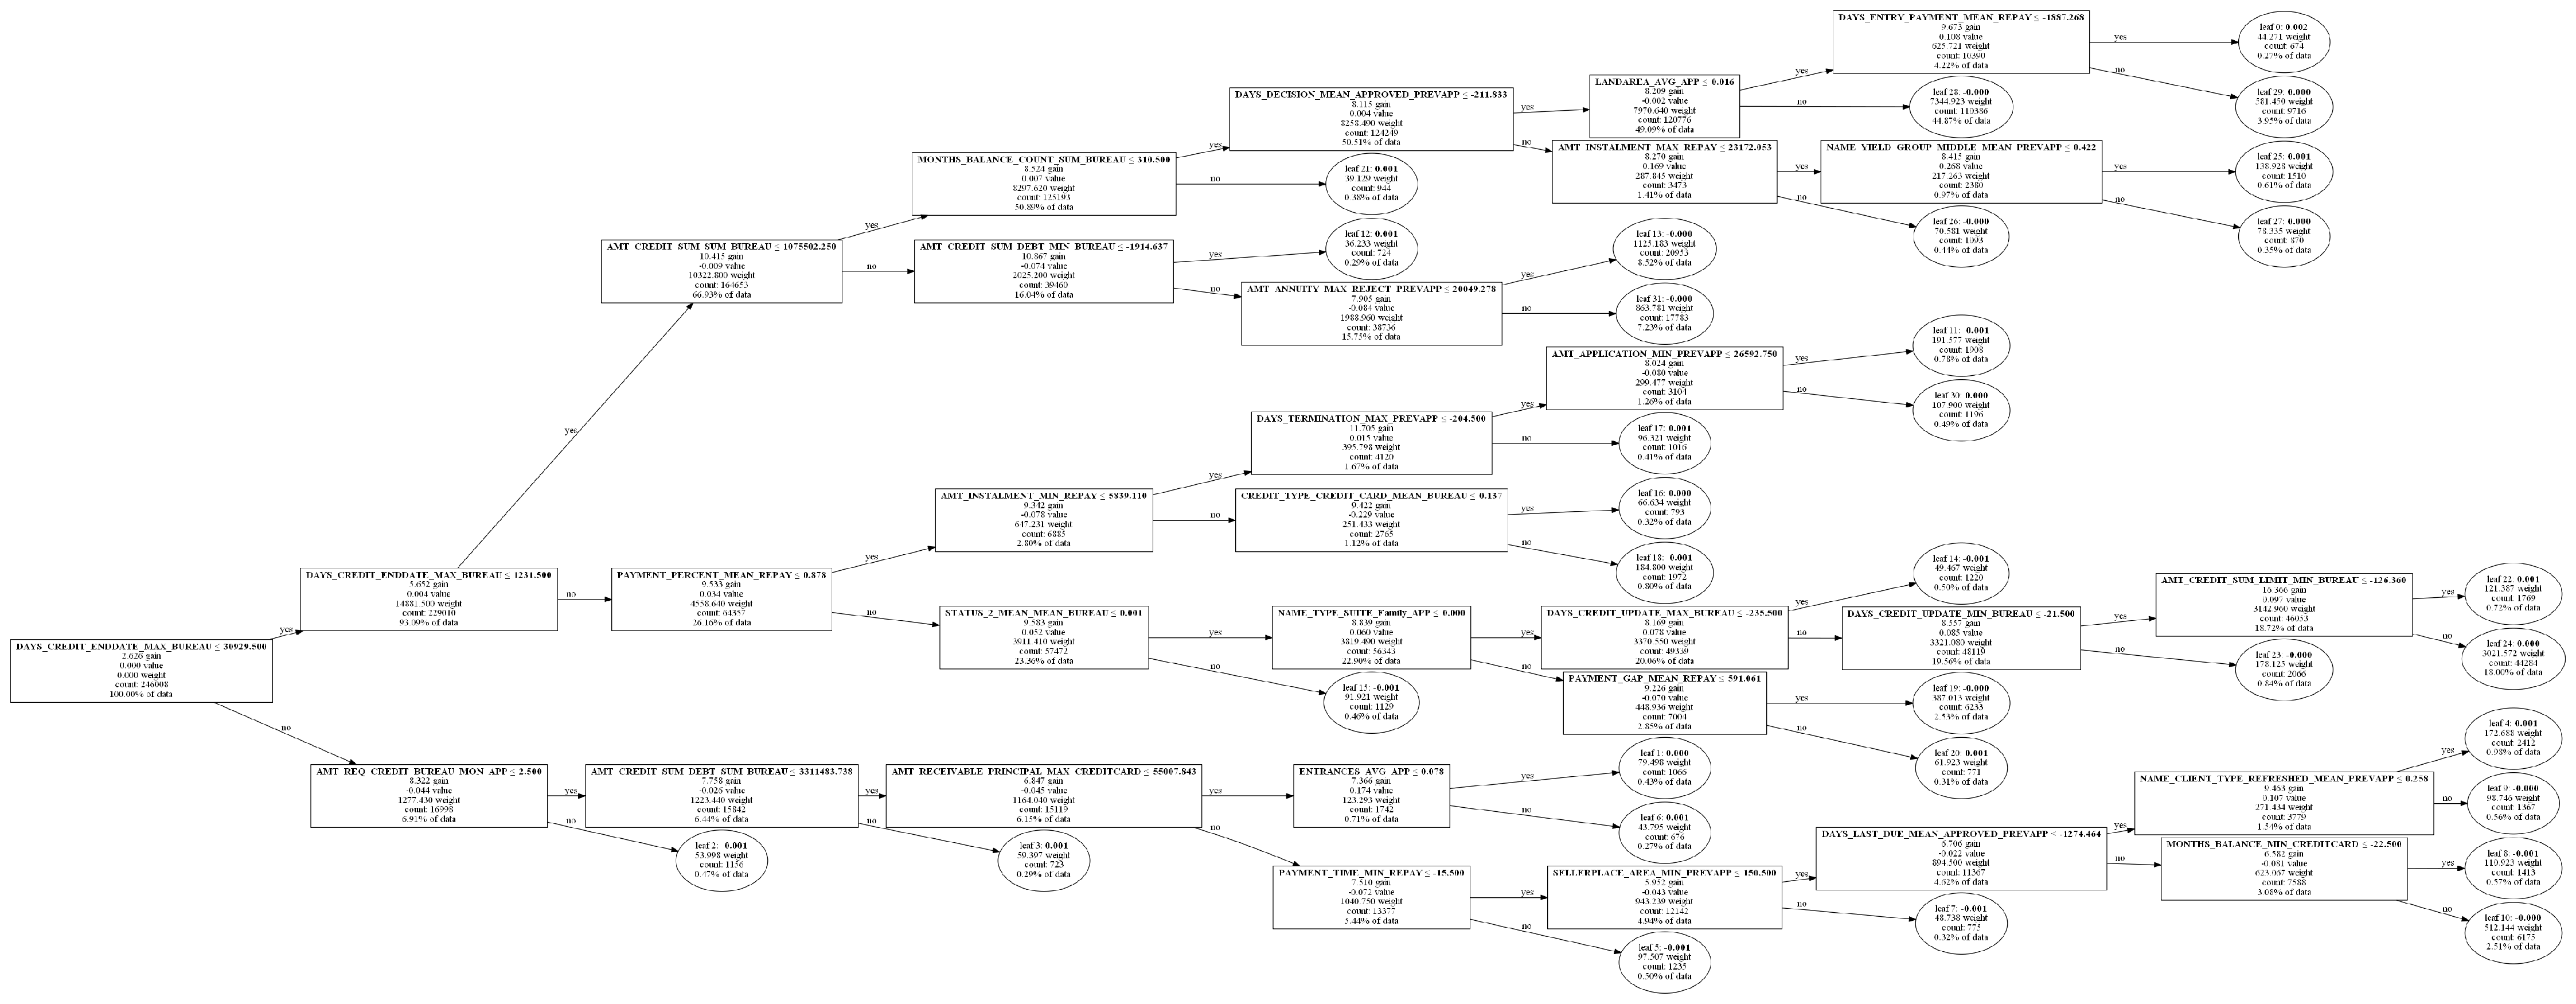

In [12]:
import lightgbm
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/graphviz-2.38/bin/'


ax = lightgbm.plot_tree(finalmodel, tree_index=7454, 
                        show_info=['split_gain', 'internal_value', 'internal_count', 'internal_weight','leaf_count', 'leaf_weight', 'data_percentage'],
                        figsize=(40,20), dpi=144)
ax.figure.savefig('plot/tree_plot.png')

### Kaggle submission

In [13]:
kaggle = pd.read_csv('cleandata/kaggle_test.csv')
kaggle.fillna(np.nan, inplace=True)
kaggle.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in kaggle.columns]
kaggle.replace([np.inf, -np.inf], np.nan, inplace=True)

In [14]:
kaggle.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN_APP,AMT_INCOME_TOTAL_APP,AMT_CREDIT_APP,AMT_ANNUITY_APP,AMT_GOODS_PRICE_APP,REGION_POPULATION_RELATIVE_APP,DAYS_BIRTH_APP,DAYS_EMPLOYED_APP,...,PAYMENT_PERCENT_MAX_REPAY,PAYMENT_PERCENT_MEAN_REPAY,PAYMENT_GAP_MIN_REPAY,PAYMENT_GAP_MAX_REPAY,PAYMENT_GAP_MEAN_REPAY,PAYMENT_GAP_SUM_REPAY,PAYMENT_TIME_MIN_REPAY,PAYMENT_TIME_MAX_REPAY,PAYMENT_TIME_MEAN_REPAY,PAYMENT_TIME_SUM_REPAY
0,100001,NaN,0,135000.0,568800.0,20560.5,450000.0,0.018850,-19241,-2329.0,...,1.0,1.000000,0.0,0.00,0.000000,0.000,-36.0,11.0,-7.285714,-51.0
1,100005,NaN,0,99000.0,222768.0,17370.0,180000.0,0.035792,-18064,-4469.0,...,1.0,1.000000,0.0,0.00,0.000000,0.000,-37.0,1.0,-23.555556,-212.0
2,100013,NaN,0,202500.0,663264.0,69777.0,630000.0,0.019101,-20038,-4458.0,...,1.0,0.935484,0.0,23147.82,1157.662742,179437.725,-38.0,21.0,-5.180645,-803.0
3,100028,NaN,2,315000.0,1575000.0,49018.5,1575000.0,0.026392,-13976,-1866.0,...,1.0,0.911504,0.0,8505.00,622.550708,70348.230,-19.0,7.0,-3.000000,-339.0
4,100038,NaN,1,180000.0,625500.0,32067.0,625500.0,0.010032,-13040,-2191.0,...,1.0,1.000000,0.0,0.00,0.000000,0.000,-18.0,-9.0,-12.250000,-147.0


In [15]:
x_kaggle = kaggle[list(kaggle.columns[2:])]

In [16]:
kaggle['TARGET'] = finalmodel.predict_proba(x_kaggle)[:,1]

In [17]:
kaggle.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN_APP,AMT_INCOME_TOTAL_APP,AMT_CREDIT_APP,AMT_ANNUITY_APP,AMT_GOODS_PRICE_APP,REGION_POPULATION_RELATIVE_APP,DAYS_BIRTH_APP,DAYS_EMPLOYED_APP,...,PAYMENT_PERCENT_MAX_REPAY,PAYMENT_PERCENT_MEAN_REPAY,PAYMENT_GAP_MIN_REPAY,PAYMENT_GAP_MAX_REPAY,PAYMENT_GAP_MEAN_REPAY,PAYMENT_GAP_SUM_REPAY,PAYMENT_TIME_MIN_REPAY,PAYMENT_TIME_MAX_REPAY,PAYMENT_TIME_MEAN_REPAY,PAYMENT_TIME_SUM_REPAY
0,100001,0.042949,0,135000.0,568800.0,20560.5,450000.0,0.018850,-19241,-2329.0,...,1.0,1.000000,0.0,0.00,0.000000,0.000,-36.0,11.0,-7.285714,-51.0
1,100005,0.124914,0,99000.0,222768.0,17370.0,180000.0,0.035792,-18064,-4469.0,...,1.0,1.000000,0.0,0.00,0.000000,0.000,-37.0,1.0,-23.555556,-212.0
2,100013,0.025392,0,202500.0,663264.0,69777.0,630000.0,0.019101,-20038,-4458.0,...,1.0,0.935484,0.0,23147.82,1157.662742,179437.725,-38.0,21.0,-5.180645,-803.0
3,100028,0.036932,2,315000.0,1575000.0,49018.5,1575000.0,0.026392,-13976,-1866.0,...,1.0,0.911504,0.0,8505.00,622.550708,70348.230,-19.0,7.0,-3.000000,-339.0
4,100038,0.124010,1,180000.0,625500.0,32067.0,625500.0,0.010032,-13040,-2191.0,...,1.0,1.000000,0.0,0.00,0.000000,0.000,-18.0,-9.0,-12.250000,-147.0


In [18]:
kaggle[['SK_ID_CURR','TARGET']].to_csv('lightgbm_submission.csv',index=False)